# 1. Problem Overview

Predicting patient outcomes in the intensive care unit (ICU) is a critical challenge. Early identification of patients at high risk of mortality enables clinicians to prioritize interventions, allocate resources efficiently, and improve overall patient care. Machine learning and statistical modeling approaches can serve as powerful tools for improving outcome prediction as they can capture complex relationships and patterns inherent in patient data. 

However, due to the high dimensionality, missingness, and correlations present in ICU datasets, it is critical to develop models that balance predictive performance with interpretability and clinical practicality. Logistic regression models offer simple and interpretable quantifications of the associations between predictors and outcomes, whereas random forests can model complex, nonlinear relationships and interactions between variables.

By applying both of these methods to ICU data collected within the first 24 hours of admission, this project aims to identify key predictors of patient mortality and construct a predictive model. Through evaluation metrics such as area under the curve (AUC) and precision and recall, we will demonstrate the feasibility of implementing our model in real-world ICU settings to support timely and evidence-based decision making. 

# 2. Finalized Research Question
How can logistic regression and random forest models be used to predict the risk of patient mortality in the intensive care unit (ICU) within the first 24 hours of admission?

# 3. Data Overview

This project utilizes a publicly available dataset collected by MIT’s Global Open Source Severity of Illness Score (GOSSIS) community initiative. The dataset includes comprehensive clinical information from over 130,000 ICU visits recorded over the course of one year. Data were aggregated from more than 200 hospitals across multiple countries, including the United States, Argentina, Australia, New Zealand, Sri Lanka, and Brazil, reflecting a diverse and globally representative ICU population. The dataset’s target variable is hospital mortality, while the predictor variables include a wide range of clinically relevant features collected within the first 24 hours of ICU admission.

The datasets used for model training, selection, and evaluation in this project include:
- `training_v2.csv`: Contains 91,713 encounters along with associated clinical factors for model training.
- `unlabeled.csv`: Contains the same clinical features but lacks the `hospital_death` outcome; this dataset will be used for generating predictions.
- `WiDS Datathon 2020 Dictionary.csv`: Provides supplemental information on the dataset, including detailed descriptions of the predictors and clinical factors.

The response variable for this project is `hospital_death`, a binary outcome where 0 indicates the patient survived and 1 indicates the patient deceased. The remaining 185 columns serve as potential predictors. The objective is to perform feature selection to reduce the model to ≤10 non-collinear predictors, and then apply the simplified model to generate predictions on the unlabeled.csv dataset.

**Note**: Some columns may not be suitable as potential predictors. For example, `encounter_id` is unlikely to be informative for predicting `hospital_death`. The team will conduct a thorough manual review to identify and remove any columns that are not appropriate for inclusion as predictors.

**Note**: There are several ethical considerations we will have to keep in mind while using this dataset. For instance, clinical datasets of this nature contain highly sensitive and private information, so the dataset should remain de-identified and comply with ethical standards when reusing it. Also, differences in healthcare quality and resource availability across hospitals from diverse countries could introduce systemic bias.

In [1]:
# load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 3.1 Summary of Data

In [2]:
df = pd.read_csv("data/training_v2.csv") # load the dataset
df.head() # exploratory summary of the dataset

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [3]:
print(f"Shape of dataset: {df.shape}\n")
print("Column data types:")
print(df.dtypes)
print("\nDescriptive statistics:")
display(df.describe(include='all'))

Shape of dataset: (91713, 186)

Column data types:
encounter_id                     int64
patient_id                       int64
hospital_id                      int64
hospital_death                   int64
age                            float64
                                ...   
leukemia                       float64
lymphoma                       float64
solid_tumor_with_metastasis    float64
apache_3j_bodysystem            object
apache_2_bodysystem             object
Length: 186, dtype: object

Descriptive statistics:


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90318,91688,90379.000000,...,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90051,90051
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,10
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Caucasian,M,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cardiovascular,Cardiovascular
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70684,49469,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29999,38816
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,NaN,NaN,169.641588,...,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638,NaN,NaN
std,37795.088538,37811.252183,62.854406,0.280811,16.775119,8.275142,0.387271,NaN,NaN,10.795378,...,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169,NaN,NaN
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,NaN,NaN,137.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,32852.000000,32830.000000,47.000000,0.000000,52.000000,23.641975,0.000000,NaN,NaN,162.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,65665.000000,65413.000000,109.000000,0.000000,65.000000,27.654655,0.000000,NaN,NaN,170.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,98342.000000,98298.000000,161.000000,0.000000,75.000000,32.930206,0.000000,NaN,NaN,177.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN


## 3.2 Histogram
Since there are 186 columns, we only selected a few among the numeric columns that might play a role as a significant predictor to gain an overview of their distributions.

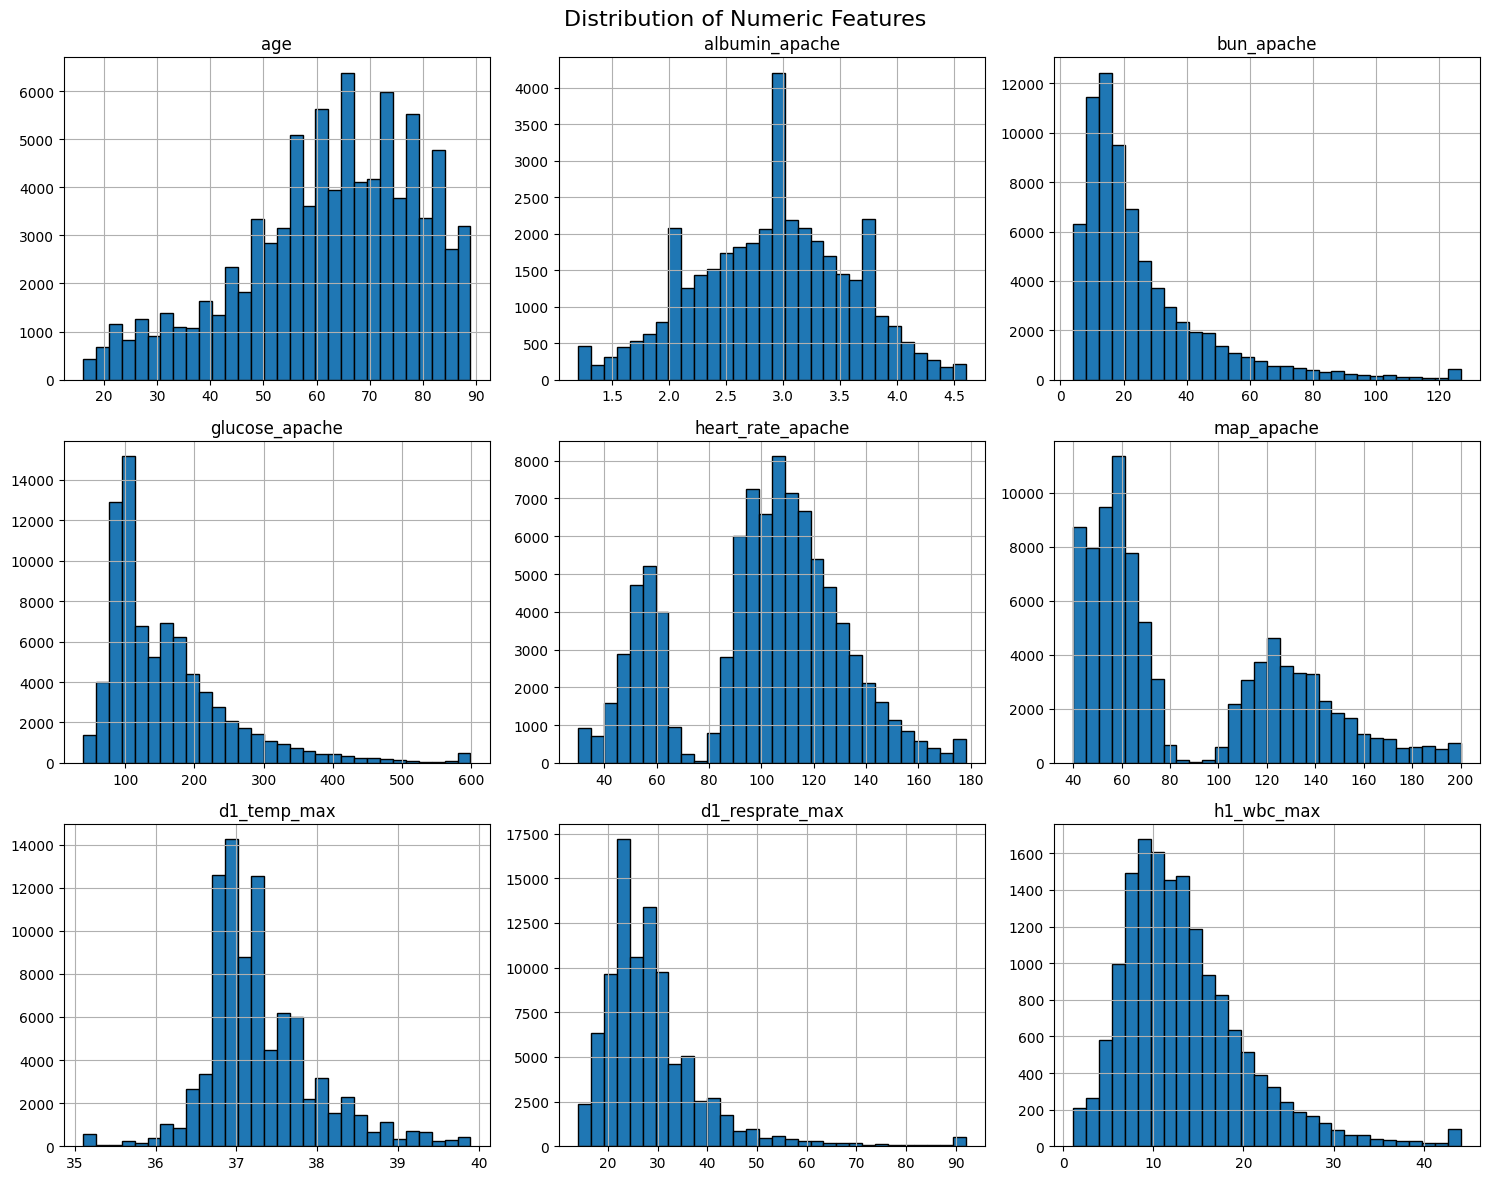

In [4]:
initial_selection = ['age', 'albumin_apache', 'bun_apache', 'glucose_apache', 'heart_rate_apache', 'map_apache', 'd1_temp_max', 'd1_resprate_max', 'h1_wbc_max']
df[initial_selection].hist(figsize=(15, 12), bins=30, edgecolor='black')
plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show();

# 4. Data Issues

## 4.1 Data Missingness 
We first examined the missingness in our dataset. Excluding the response variable `hospital_death`, the dataset contains a total of 185 potential predictors. We performed a preliminary check on the percentage of missing values in each predictor and observed the following:
- 70 predictors have missingness ≤ 5%, where missing data can be imputed relatively confidently using standard imputation methods.
- 33 predictors have missingness between 5% and 20%.
- 82 predictors have missingness > 20%, making imputation more challenging and potentially less reliable.

We also examined data missingness in survived (`'hospital_death' == 0`) and deceased (`'hospital_death' == 1`) populations. The bars for both groups largely overlap at low missingness, suggesting missingness is fairly similar across the two groups for most predictors. At higher missingness, there is a slight difference, but overall it seems the missingness pattern is not drastically different between the groups.

Based on a review of the literature, we decided to select a cutoff value of [???]% to mitigate potential bias that may arise from handling missing data through imputation or alternative methods, depending on the nature of each predictor. The team will further discuss the most appropriate strategy for addressing missing values.

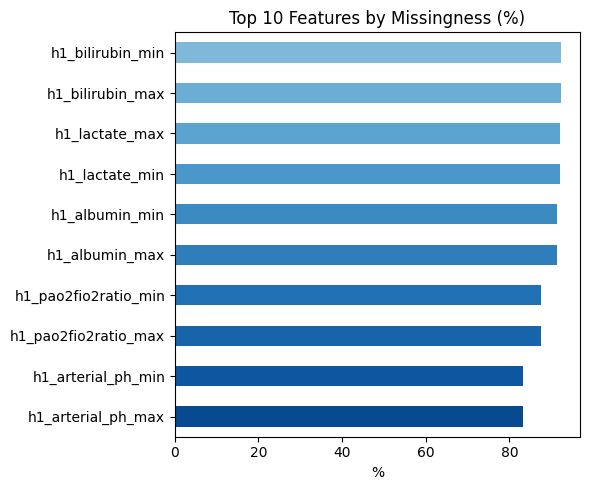

In [5]:
colors = plt.cm.Blues(np.linspace(0.45, 0.9, 10))
na_percent = df.drop(columns=['hospital_death'], errors='ignore').isna().mean()*100
ax = (na_percent.sort_values(ascending=False)
      .head(10)
      .plot(kind='barh', figsize=(6,5), color=colors))
ax.invert_yaxis()
ax.set_title("Top 10 Features by Missingness (%)")
ax.set_xlabel("%")
plt.tight_layout();

Number of predictors with <= 5% missingness: 70
Number of predictors with 5-20% missingness: 33
Number of predictors with > 20% missingness: 82
Percentage of missingness in hospital_death: 0.0
Number of categorical predictors with <= 5% missingness: 7
Number of categorical predictors with 5-20% missingness: 0
Number of categorical predictors with > 20% missingness: 1


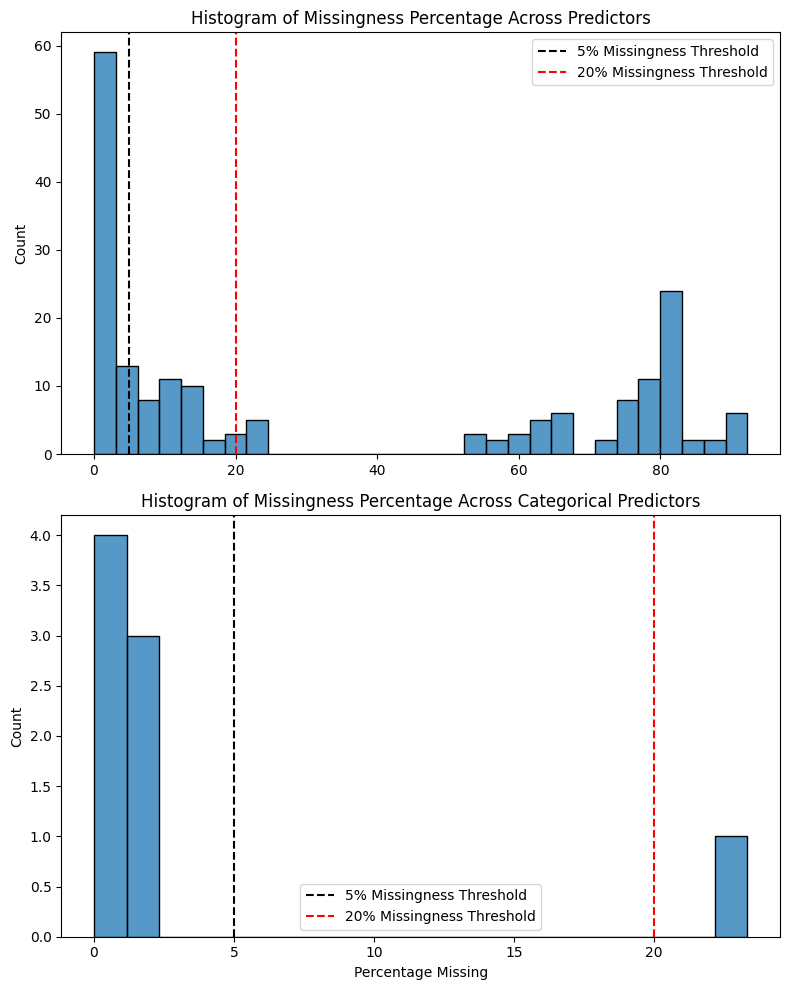

In [6]:
df.isna().sum()

#   ======== EXAMINE MISSINGNESS IN NUMERICAL COLUMNS ========
# calculate persontage of missingness for each column
na_percent = df.isna().mean() * 100
na_percent = na_percent.drop('hospital_death') # drop response variable
na_percent = na_percent.sort_values(ascending=True)

# visualize percentage of missingness
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
sns.histplot(na_percent, bins=30, ax=ax1)
ax1.axvline(x=5, color='k', linestyle='--', label='5% Missingness Threshold')
ax1.axvline(x=20, color='red', linestyle='--', label='20% Missingness Threshold')
ax1.set_title("Histogram of Missingness Percentage Across Predictors")
ax1.legend()

# display stats
print(f'Number of predictors with <= 5% missingness: {sum(na_percent <= 5)}')
print(f'Number of predictors with 5-20% missingness: {sum((na_percent > 5) & (na_percent <= 20))}')
print(f'Number of predictors with > 20% missingness: {sum(na_percent > 20)}')

# calculate % missingness in response
print(f"Percentage of missingness in hospital_death: {df['hospital_death'].isna().mean() * 100}")

#   ======== EXAMINE MISSINGNESS IN CATEGORICAL COLUMNS ========
# select only categorical/object columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# calculate missing counts & percentages for categorical columns
cat_na_count = df[cat_cols].isna().sum()
cat_na_percent = df[cat_cols].isna().mean() * 100
cat_na_percent = cat_na_percent.sort_values(ascending=True)

# visualize missingness
sns.histplot(cat_na_percent, bins=20, ax=ax2)
ax2.axvline(x=5, color='k', linestyle='--', label='5% Missingness Threshold')
ax2.axvline(x=20, color='red', linestyle='--', label='20% Missingness Threshold')
ax2.set_title("Histogram of Missingness Percentage Across Categorical Predictors")
ax2.set_xlabel("Percentage Missing")
ax2.legend()
fig.tight_layout()

# display stats
print(f'Number of categorical predictors with <= 5% missingness: {sum(cat_na_percent <= 5)}')
print(f'Number of categorical predictors with 5-20% missingness: {sum((cat_na_percent > 5) & (cat_na_percent <= 20))}')
print(f'Number of categorical predictors with > 20% missingness: {sum(cat_na_percent > 20)}')

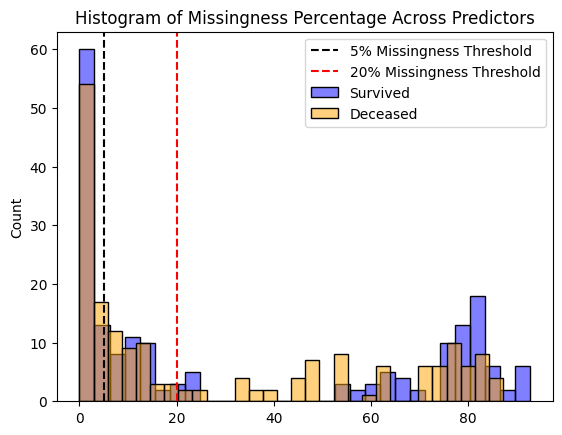

In [7]:
# visualize percentage of missingness by response variable
df_survived = df[df['hospital_death'] == 0]
df_deceased = df[df['hospital_death'] == 1]

fig, ax = plt.subplots()
sns.histplot(df_survived.isna().mean() * 100, bins=30, ax=ax, color='blue', alpha=0.5, label='Survived')
sns.histplot(df_deceased.isna().mean() * 100, bins=30, ax=ax, color='orange', alpha=0.5, label='Deceased')
ax.axvline(x=5, color='k', linestyle='--', label='5% Missingness Threshold')
ax.axvline(x=20, color='red', linestyle='--', label='20% Missingness Threshold')
ax.set_title("Histogram of Missingness Percentage Across Predictors")
ax.legend();

## 4.2 Data Imbalance
We examined the class distribution of our target variable `hospital_death`, and found a significant imbalance: 83,798 patients survived, while 7,915 patients did not. Due to this pronounced imbalance, we decided to incorporate resampling techniques during model training to mitigate its impact and improve the model’s performance on the minority class.

In [8]:
df['hospital_death'].value_counts()

hospital_death
0    83798
1     7915
Name: count, dtype: int64

In [9]:
imbalance_ratio = df['hospital_death'].value_counts(normalize=True)
print(imbalance_ratio)

hospital_death
0    0.913698
1    0.086302
Name: proportion, dtype: float64


## 4.3 Data Scaling
We began by removing all ID-related columns to ensure that identifier values were not treated as quantitative predictors. After doing so, we observed that most features have very small ranges, clustered near zero, while a few features have extremely large ranges (e.g., one reaching ~80,000). This is a classic case of features on widely different scales, meaning some features could dominate model training if not scaled.

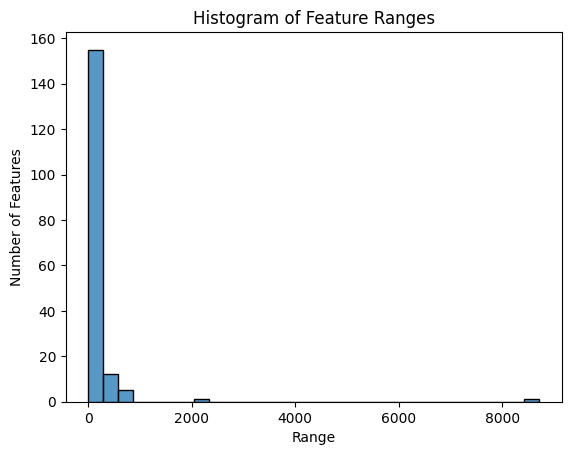

In [10]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop(['encounter_id', 'patient_id', 'hospital_id', 'icu_id'])
df[numeric_cols].describe() # exploratory summary

# visualize feature ranges
ranges = df[numeric_cols].max() - df[numeric_cols].min()
fig, ax = plt.subplots()
sns.histplot(ranges, bins=30, edgecolor='k')
ax.set_title("Histogram of Feature Ranges")
ax.set_xlabel("Range")
ax.set_ylabel("Number of Features");

After removing ID-related variables, we examined the distribution of feature ranges to identify differences in scale across numerical predictors. The plot below shows the top 10 features with the largest value ranges.

Key observations:

- **`urineoutput_apache`** has the widest range. According to the data dictionary, this represents urine output prior to ICU admission (used in the APACHE score). Urine output varies widely in critically ill patients, from anuric kidney failure to high-output states, making a large range clinically plausible.

- **`apache_3j_diagnosis`** also shows a large range. This feature represents APACHE diagnostic categories encoded as numeric values. Although it is stored as a number, it functions as a *categorical* variable rather than a continuous physiologic measurement. Its wide numerical spread reflects category codes, not quantitative magnitude. This suggests that additional preprocessing is needed to ensure these encoded values are treated as categorical labels rather than continuous numeric inputs, and to prevent string-like numeric codes without quantitative meaning from influencing model training.

- Several physiologic variables also appear among the largest-range features, including:
  - **PaO₂/FiO₂ ratio** (`d1_pao2fio2ratio_max`, `h1_pao2fio2ratio_max`, `d1_pao2fio2ratio_min`, `h1_pao2fio2ratio_min`), a key indicator of oxygenation
  - **Glucose** (`h1_glucose_max`, `h1_glucose_min`), reflecting metabolic disturbances common in ICU patients
  - **Platelets** (`h1_platelets_min`, `h1_platelets_max`), which can vary due to bleeding, sepsis, or bone marrow dysfunction

These findings highlight substantial variation in feature scales across the dataset. Without proper preprocessing, high-range features may dominate model training. This reinforces the need for feature scaling (e.g., standardization or normalization) to ensure balanced contribution from all variables.

urineoutput_apache      8716.669632
apache_3j_diagnosis     2201.040000
d1_pao2fio2ratio_max     780.005000
h1_pao2fio2ratio_max     678.000000
h1_glucose_max           636.045000
h1_glucose_min           628.000000
h1_pao2fio2ratio_min     616.813793
d1_pao2fio2ratio_min     568.227778
h1_platelets_min         565.000000
h1_platelets_max         565.000000
dtype: float64


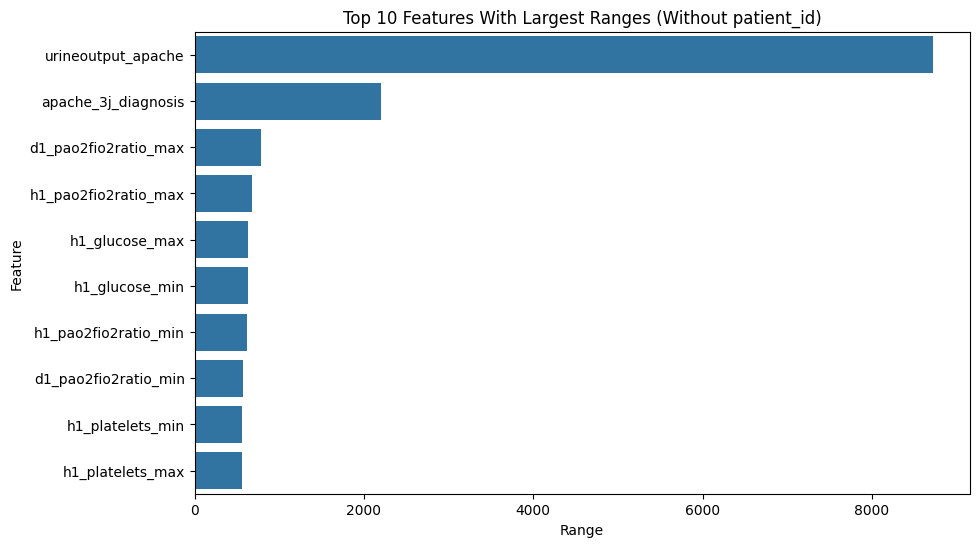

In [11]:
# sort and display
range_sorted = ranges.sort_values(ascending=False)
print(range_sorted.head(10))

# plot top 10 features with largest ranges
plt.figure(figsize=(10,6))
sns.barplot(x=range_sorted.head(10).values, y=range_sorted.head(10).index)
plt.title("Top 10 Features With Largest Ranges (Without patient_id)")
plt.xlabel("Range")
plt.ylabel("Feature")
plt.show();

We also want to examine whether categorical variables exist and how to encode them.

In [12]:
cat_cols = df.select_dtypes(include=["object", "category"]).columns
print("Categorical columns:", list(cat_cols))

Categorical columns: ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']


Among our categorical variables, we will retain and encode the following features:
- `ethnicity`  
- `gender`  
- `apache_3j_bodysystem`  
- `apache_2_bodysystem`  
We exclude variables such as `hospital_admit_source`, `icu_admit_source`, `icu_stay_type`, and `icu_type`, as they  primarily capture administrative or operational details and are unlikely to have a direct causal relationship with mortality.

In [13]:
cat_cols = ['ethnicity', 'gender', 'apache_3j_bodysystem', 'apache_2_bodysystem']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("Original shape:", df.shape)
print("Encoded shape:", df_encoded.shape)

encoded_cols = [col for col in df_encoded.columns if any(base in col for base in cat_cols)]
print("Example of encoded columns:", encoded_cols[:10])
df_encoded.head()

Original shape: (91713, 186)
Encoded shape: (91713, 207)
Example of encoded columns: ['ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown', 'gender_M', 'apache_3j_bodysystem_Gastrointestinal', 'apache_3j_bodysystem_Genitourinary', 'apache_3j_bodysystem_Gynecological', 'apache_3j_bodysystem_Hematological']


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,hospital_admit_source,icu_admit_source,...,apache_3j_bodysystem_Trauma,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses
0,66154,25312,118,0,68.0,22.73,0,180.3,Floor,Floor,...,False,False,False,False,False,False,False,False,False,False
1,114252,59342,81,0,77.0,27.42,0,160.0,Floor,Floor,...,False,False,False,False,False,False,True,False,False,False
2,119783,50777,118,0,25.0,31.95,0,172.7,Emergency Department,Accident & Emergency,...,False,False,False,True,False,False,False,False,False,False
3,79267,46918,118,0,81.0,22.64,1,165.1,Operating Room,Operating Room / Recovery,...,False,False,False,False,False,False,False,False,False,False
4,92056,34377,33,0,19.0,NaN,0,188.0,NaN,Accident & Emergency,...,True,False,False,False,False,False,False,True,False,False


After one-hot encoding, the dataset expanded from 186 to 207 columns, reflecting the creation of binary indicator variables for the selected categorical features.

## 4.4 Correlation Check
We examined pairwise correlations among numeric predictors to identify potential multicollinearity that could affect interpretability. The heatmap below shows absolute Pearson correlations among the first 15 numeric features with less than 20% missingness (excluding IDs and the label). Some variables show strong positive correlations, indicating redundancy that will be addressed during feature selection.

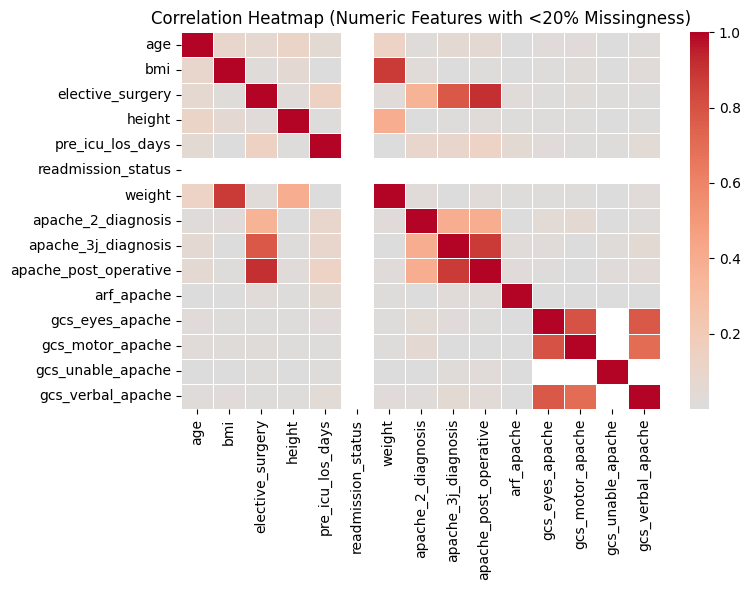

Used 92 / 173 numeric features (<20% missingness).


In [14]:
num_df = (df.select_dtypes(include=['float64', 'int64'])
              .drop(columns=['hospital_death', 'encounter_id', 'patient_id', 'hospital_id', 'icu_id'], errors='ignore'))

low_missing_cols = num_df.columns[num_df.isna().mean() < 0.20].tolist()

corr_matrix_low = num_df[low_missing_cols].corr().abs()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_low.iloc[:15, :15], cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Heatmap (Numeric Features with <20% Missingness)")
plt.tight_layout()
plt.show()

print(f"Used {len(low_missing_cols)} / {num_df.shape[1]} numeric features (<20% missingness).")

# 5. EDA
From this point forward, we will work with the original dataset. To ensure consistency and reproducibility, we will reload both the training and testing data.

In [15]:
df = pd.read_csv("data/training_v2.csv") # load the dataset
df_test = pd.read_csv("data/unlabeled.csv")

## 5.1 Feature Selection
Based on our prior analysis of missingness in the dataset, we have decided to focus our modeling efforts on a subset of features that meet defined completeness criteria. 

First, all ID-related columns will be removed. Specifically, any column in the` WiDS Datathon 2020 Dictionary`.csv labeled with a description of "identifier" will be dropped. This results in a drop of 4 columns. 

We will then focus our analysis on the 100 numeric features with less than 30% missingness. After including the binary response variable, `hospital_mortality`, this yields a total of 101 numeric columns (including id columns, which are removed at a later step) to retain for modeling.

For categorical variables, we will retain only those columns with a missingness rate below 5%, ensuring high data quality and minimizing potential biases that could arise from imputation or sparse categories. This results in a total of 7 categorical columns. 

For the purposes of predicting mortality, we will also include certain administrative-related variables as part of our predictor set. While these columns, such as `icu_admit_source`, `hospital_admit_source`, `icu_stay_type`, and `icu_type`, are primarily operational in nature, they may carry predictive value for mortality outcomes. For example, patients admitted from specific ICU sources or transfer pathways may inherently have a higher risk of adverse outcomes. Therefore, despite their administrative context, these variables will be incorporated into our predictive models to potentially improve performance, while recognizing that their inclusion is for prediction rather than causal inference.

In [16]:
# define id columns to drop
id_cols = ['encounter_id', 'hospital_id', 'patient_id', 'icu_id']
print(f"ID columns to drop ({len(id_cols)} columns):")
print(id_cols)

# keep numeric columns with <30% missingness
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# calculate missing counts & percentages for categorical columns
num_na_count = df[num_cols].isna().sum()
num_na_percent = df[num_cols].isna().mean() * 100
# num_na_percent = num_na_percent.sort_values(ascending=True)

num_cols_lt30 = num_na_percent[num_na_percent < 30].index.tolist()
num_cols_lt30 = [col for col in num_cols_lt30 if col not in id_cols] # remove id columns
num_cols_lt30 = [col for col in num_cols_lt30 if col != "hospital_death"] # remove response columns
print(f"\nNumeric columns with <30% missingness ({len(num_cols_lt30)} columns):")
print(num_cols_lt30)

# keep categorical columns with <5% missingness
cat_cols_lt5 = cat_na_percent[cat_na_percent < 5].index.tolist()
print(f"\nCategorical columns with <5% missingness ({len(cat_cols_lt5)} columns):")
print(cat_cols_lt5)

# drop columns not meeting criteria
cols_to_keep = num_cols_lt30 + cat_cols_lt5 + ['hospital_death']
df = df[cols_to_keep]
print(f"\nShape of dataset after feature selection (including both predictors and response): {df.shape}")

df_test = df_test[cols_to_keep]

ID columns to drop (4 columns):
['encounter_id', 'hospital_id', 'patient_id', 'icu_id']

Numeric columns with <30% missingness (99 columns):
['age', 'bmi', 'elective_surgery', 'height', 'pre_icu_los_days', 'readmission_status', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bun_apache', 'creatinine_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max',

## 5.2 Imputation
### 5.2.1 Benchmarking Imputation Methods
After performing feature selection using a 30% missingness threshold for numerical columns and 5% for categorical columns, we proceeded to evaluate several imputation strategies. For numerical features, we tested `SimpleImputer (mean and median)` and `KNNImputer`. For categorical features, we compared `SimpleImputer with the most frequent category` and `SimpleImputer with a constant “Missing” label`.

To assess performance, we used __RMSE for numerical imputation__ and __accuracy (percentage of correctly recovered values)__ for categorical imputation. To ensure a clean evaluation without interference from originally missing values, we restricted our benchmarking to rows that were fully observed, resulting in 34,494 complete rows. We then simulated missingness by masking 20% of the values and applied each imputation method to recover the masked entries. The reconstructed values were compared against the true values to quantify imputation performance.

In [17]:
# specify response variable
target = "hospital_death"
y = df[target]
X = df.drop(columns=[target])
X_unlabeled = df_test

# list of predictor columns
num_cols = num_cols_lt30
cat_cols = cat_cols_lt5
df[cat_cols] = df[cat_cols].astype("category") # convert categorical columns to "category" type

In [18]:
# library needed for this section
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [19]:
from sklearn.metrics import f1_score

def make_random_mask(df_nona, missing_rate=0.2, seed=42):
    rng = np.random.default_rng(seed)
    mask = pd.DataFrame(
        rng.random(df_nona.shape) < missing_rate,
        index=df_nona.index,
        columns=df_nona.columns)
    return mask

def impute(df_masked, num_cols, cat_cols, num_method, cat_method):
    df_imputed = df_masked.copy()
    # impute numerical columns
    num_vals = num_method.fit_transform(df_imputed[num_cols])
    df_imputed[num_cols] = num_vals

    # inpute categorical columns
    cat_vals = cat_method.fit_transform(df_imputed[cat_cols])
    df_imputed[cat_cols] = np.array(cat_vals).reshape(-1, len(cat_cols))

    return df_imputed

# evaluate performance of 
def evaluate_imputation(df_nona, df_imputed, mask, num_cols, cat_cols):
    # evaluate numerical cols imputations using RMSE
    all_num = df_nona[num_cols]
    imp_num = df_imputed[num_cols]
    specific_num_mask = mask[num_cols]

    # extract only the values where the mask is True (the imputed positions)
    true_num_values = all_num.values[specific_num_mask.values]
    imp_num_values = imp_num.values[specific_num_mask.values]

    # calculate RMSE
    if len(true_num_values) > 0:
        rmse = np.sqrt(mean_squared_error(true_num_values, imp_num_values))
    else:
        rmse = 0 # handle case where no values were imputed

    # evaluate categorical cols imputations using accuracy
    cat_cols_to_evaluate = df_nona[cat_cols]
    imp_cat_cols = df_imputed[cat_cols]
    specific_cat_mask = mask[cat_cols]

    true_cat_values = cat_cols_to_evaluate.values[specific_cat_mask.values]
    imp_cat_values = imp_cat_cols.values[specific_cat_mask.values]

    if len(true_cat_values) > 0:
        acc = (true_cat_values == imp_cat_values).mean()
    else:
        acc = 1.0 # Or 0, depending on context
    
    f1_macro = f1_score(true_cat_values, imp_cat_values, average="macro")

    return rmse, acc, f1_macro

In [20]:
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

# specify imputers to benchmark
num_imputers = {
  "mean": SimpleImputer(strategy="mean"),
  "median": SimpleImputer(strategy="median"),
  "knn": KNNImputer(n_neighbors=5),
  "mice": IterativeImputer(
        max_iter=10,
        random_state=42,
        sample_posterior=True
    ),
}

cat_imputers = {
    "most_frequent": SimpleImputer(strategy="most_frequent"),
    "constant_missing": SimpleImputer(strategy="constant", fill_value="Missing")
}

# use rows without NAs to evaluate performances of different imputers
df_nona = X.copy().dropna().reset_index(drop=True) # copy non NA rows for imputation becnhmarking
mask = make_random_mask(df_nona, missing_rate=0.2)
df_masked = df_nona.mask(mask)

results = [] # initialize a list to store result

for num_name, num_imp in num_imputers.items():
    for cat_name, cat_imp in cat_imputers.items():
        df_imputed = impute(df_masked, num_cols, cat_cols, num_imp, cat_imp)
        rmse, acc, f1_macro = evaluate_imputation(df_nona, df_imputed, mask, num_cols, cat_cols)
        results.append({"num_method": num_name, "cat_method": cat_name, "RMSE": rmse, "Accuracy": acc, "F1_Macro": f1_macro})

results = pd.DataFrame(results)
results

,num_method,cat_method,RMSE,Accuracy,F1_Macro
0,mean,most_frequent,52.867984,0.588079,0.113166
1,mean,constant_missing,52.867984,0.000000,0.000000
2,median,most_frequent,54.052210,0.588079,0.113166
3,median,constant_missing,54.052210,0.000000,0.000000
4,knn,most_frequent,45.802525,0.588079,0.113166
5,knn,constant_missing,45.802525,0.000000,0.000000
6,mice,most_frequent,41.105442,0.588079,0.113166
7,mice,constant_missing,41.093231,0.000000,0.000000


### 5.2.2 Choice of Imputers for Numerical and Categorical Columns
Based on the benchmarking results, the `median imputer` achieved the best performance for numerical columns, while the` most frequent imputer` performed best for categorical columns. Using these findings, we constructed a preprocessing pipeline that applies __median imputation and scaling__ to numerical features, and __most-frequent imputation followed by one-hot encoding__ to categorical features.

In [21]:
# define transformers
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

## 5.3 Principle Component Analysis
After data imputation and preprocessing, we applied Principal Component Analysis to better understand the intrinsic structure of the dataset. 

In [22]:
X_processed = preprocess.fit_transform(X)
if hasattr(X_processed, "toarray"):
    X_dense = X_processed.toarray()
else:
    X_dense = X_processed

feature_names = preprocess.get_feature_names_out()
X_processed_df = pd.DataFrame(X_dense, columns=feature_names)
X_processed_df.head()

,num__age,num__bmi,num__elective_surgery,num__height,num__pre_icu_los_days,num__readmission_status,num__weight,num__apache_2_diagnosis,num__apache_3j_diagnosis,num__apache_post_operative,...,cat__apache_2_bodysystem_Cardiovascular,cat__apache_2_bodysystem_Gastrointestinal,cat__apache_2_bodysystem_Haematologic,cat__apache_2_bodysystem_Metabolic,cat__apache_2_bodysystem_Neurologic,cat__apache_2_bodysystem_Renal/Genitourinary,cat__apache_2_bodysystem_Respiratory,cat__apache_2_bodysystem_Trauma,cat__apache_2_bodysystem_Undefined Diagnoses,cat__apache_2_bodysystem_Undefined diagnoses
0,0.339552,-0.787602,-0.474441,0.993943,-0.118219,0.0,-0.406470,-0.831561,-0.118099,-0.501727,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.888550,-0.210308,-0.474441,-0.900304,0.036986,0.0,-0.556597,-0.889914,-0.767024,-0.501727,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-2.283438,0.347291,-0.474441,0.284766,-0.335674,0.0,0.461833,-0.726526,0.318179,-0.501727,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.132549,-0.798680,2.107744,-0.424410,-0.335674,0.0,-0.901483,0.218791,1.409849,1.993116,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.649436,-0.181425,-0.474441,1.712450,-0.306364,0.0,-0.146790,-0.761538,0.096763,-0.501727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [23]:
from sklearn.decomposition import PCA
pca_full = PCA().fit(X_processed)
explained = pca_full.explained_variance_ratio_
print("First 10 PCs:", explained[:10])
print("Cumulative variance (first 10):", explained[:10].sum())
cumulative_var = np.cumsum(explained)
num_components_90 = np.argmax(cumulative_var >= 0.90) + 1
print(f"Number of components needed for 90% variance: {num_components_90}")

First 10 PCs: [0.14348298 0.06848723 0.0518946  0.04807732 0.04400161 0.03892715
 0.03161387 0.02836294 0.02630176 0.02400367]
Cumulative variance (first 10): 0.505153117742043
Number of components needed for 90% variance: 46


We found that the first 46 principal components were required to explain 90% of the variance, indicating that the ICU dataset is highly heterogeneous and cannot be captured in only a few dimensions.

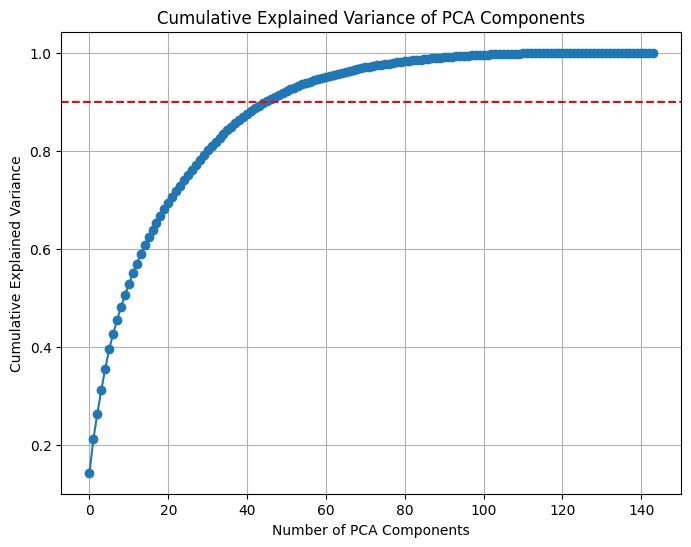

In [24]:
plt.figure(figsize=(8,6))
plt.plot(cumulative_var, marker='o')
plt.axhline(0.90, color='red', linestyle='--')
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance of PCA Components")
plt.grid(True)
plt.show()

For visualization, we projected the data onto the first two principal components which explain about 20 percent of total variance. The scatter plot shows substantial overlap between survivors and non-survivors, suggesting that hospital mortality is not linearly separable in the most dominant directions of variance.

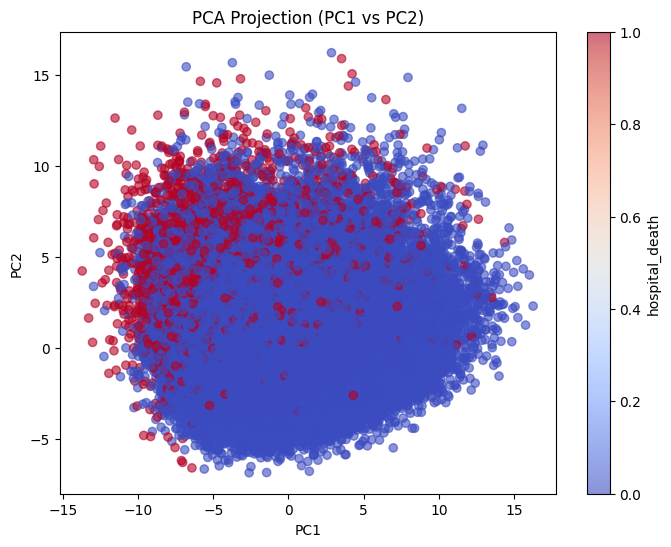

In [25]:
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_processed)
plt.figure(figsize=(8,6))
plt.scatter(X_pca_2[:,0], X_pca_2[:,1], c=y, cmap="coolwarm", alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection (PC1 vs PC2)")
plt.colorbar(label="hospital_death")
plt.show()

## 5.4 K-means Clustering
To further explore potential patient subgroups, we applied KMeans clustering to the PCA-reduced data. Because the first 46 principal components captured approximately 90% of the total variance, we performed KMeans in the 46-dimensional PCA space.

To evaluate cluster quality, we computed Silhouette scores on a 5000 sample subset of the PCA-46 representation. The highest Silhouette score occurred at k = 2 and consistently declined as k increased. This indicates that the dataset does not contain naturally well-separated high-order clusters, and increasing the number of clusters beyond three leads to over-partitioning rather than discovering meaningfully distinct groups.

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pca_46 = PCA(n_components=46)
X_pca_46 = pca_46.fit_transform(X_processed)

sample_idx = np.random.choice(len(X_pca_46), size=5000, replace=False)
X_sample = X_pca_46[sample_idx]

sil_scores = {}
cluster_assignments = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters_46 = kmeans.fit_predict(X_pca_46)
    cluster_assignments[k] = clusters_46 
    
    clusters_sample = kmeans.predict(X_sample)
    sil = silhouette_score(X_sample, clusters_sample)
    sil_scores[k] = sil

sil_scores

{2: np.float64(0.09880885964840418),
 3: np.float64(0.07581194892301722),
 4: np.float64(0.04962670159190963),
 5: np.float64(0.04770257437561701),
 6: np.float64(0.0500419676529893),
 7: np.float64(0.04293138988601509),
 8: np.float64(0.02593921613344255),
 9: np.float64(0.040509124850717795)}

We then visualized the clusters in the 2D PCA space using the first two principal components. Although the clusters appear cleanly separated in the plot, PC1 and PC2 together explain only about 20% of the total variance, so this apparent separation does not reflect true geometric separability in the original high-dimensional space.

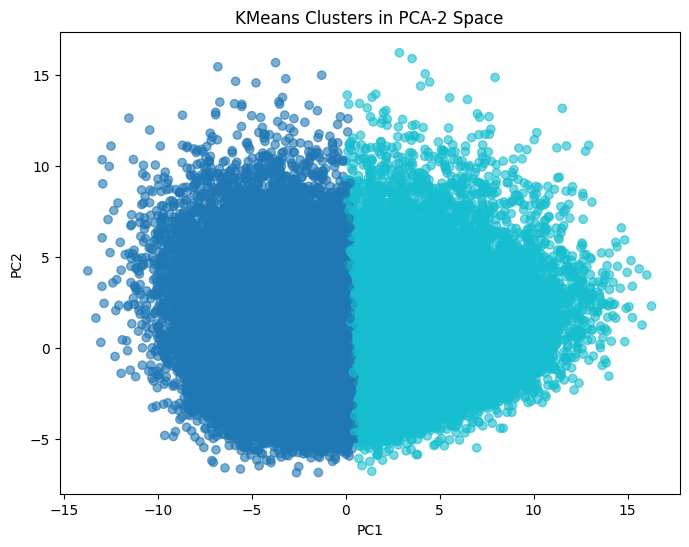

In [27]:
k = 2
clusters_k = cluster_assignments[k]
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=clusters_k, cmap="tab10", alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters in PCA-2 Space")
plt.show()

Calculating the mortality rate for each cluster, we found a clear difference between the two clusters, indicating possible underlying risk stratification in the patient population.

In [28]:
cluster_series = pd.Series(clusters_k, index=y.index) 
mortality_by_cluster = y.groupby(cluster_series).mean()

print("Cluster-level mortality rates:")
print(mortality_by_cluster)

Cluster-level mortality rates:
0    0.116403
1    0.047953
Name: hospital_death, dtype: float64


# 6. Baseline Model -- Logistic Regression Model 
As our first basic model, we used logistic regression that predicts `hospital_death` using predictors preprocessed from above.  

### 6.1 Multiple Logistic Regression Model using 10-fold stratified cross-validation 
Our baseline model uses a multiple logistic regression classifier trained on preprocessed predictors to predict hospital_death. Overall, the model demonstrates strong discrimination ability, but also reveals clear limitations that motivate the need for more advanced modeling.

#### Model Architecture
We use Multiple Logistic Regression presented in the class:

$$
\ln\left( \frac{P(Y = 1 \mid X)}{1 - P(Y = 1 \mid X)} \right)
= \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p .
$$

Define the linear predictor:

$$
z = \beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p .
$$

$$
P(Y = 1 \mid X) = \sigma(z)
= \frac{1}{1 + e^{-z}} .
$$

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
)

# modeling pipeline 
logreg = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

##### Cross-Validation Performance

Using 10-fold stratified cross-validation: **Mean Accuracy: ~0.925**, **Mean ROC AUC: ~0.878**

These values are consistent across folds, suggesting a stable model that generalizes reasonably well. The AUC close to 0.88 indicates that the model can reliably distinguish between survivors and non-survivors.

In [30]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_results = cross_validate(
    logreg,
    X,
    y,
    cv=cv,
    scoring=["accuracy", "roc_auc"],
    return_train_score=False
)

print("Accuracy:", cv_results["test_accuracy"].mean())
print("ROC AUC:", cv_results["test_roc_auc"].mean())

Accuracy: 0.9245690151405886
ROC AUC: 0.8767686638551938


In [31]:
pd.DataFrame(cv_results)

,fit_time,score_time,test_accuracy,test_roc_auc
0,2.001464,0.050910,0.924008,0.874126
1,1.994576,0.051312,0.925534,0.878213
2,1.871473,0.051026,0.926079,0.880028
3,1.969589,0.047847,0.923781,0.875919
4,1.865451,0.048629,0.924109,0.871084
5,1.903577,0.048728,0.925308,0.875876
6,2.115303,0.051202,0.922582,0.878442
7,1.951205,0.048051,0.927816,0.879720
8,2.007186,0.053221,0.924218,0.872459
9,2.065436,0.048769,0.922255,0.881820


In [32]:
logreg.fit(X, y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi',
                                                   'elective_surgery', 'height',
                                                   'pre_icu_los_days',
                                                   'readmission_status',
                                                   'weight',
                                                   'apache_2_diagnosis',
                                                   'apache_3j_diagnosis',
                                                   'apache_post_operative',
                                                   'arf_apache', 'bun_apache',
                                                   'creati...
                                                   'd1_diasbp_max',
                                                   'd1_diasbp_min',
                                                   'd1_diasbp_noninvasive_max', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['icu_stay_type', 'icu_type',
                                                   'gender', 'icu_admit_source',
                                                   'ethnicity',
                                                   'apache_3j_bodysystem',
                                                   'apache_2_bodysystem'])])),
                ('model', LogisticRegression(max_iter=1000))])

##### Performance on the Full Training Set

Accuracy: 0.925
ROC AUC: 0.879

The agreement between cross-validated and full-sample AUC confirms that the model is neither highly overfitted nor underfitted.

In [33]:
y_pred = logreg.predict(X)
y_prob = logreg.predict_proba(X)[:, 1]

print("Accuracy:", accuracy_score(y, y_pred))
print("ROC AUC:", roc_auc_score(y, y_prob))
print("\nClassification Report:\n", classification_report(y, y_pred))

Accuracy: 0.9252341543728806
ROC AUC: 0.8789869652704078

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     83798
           1       0.66      0.27      0.39      7915

    accuracy                           0.93     91713
   macro avg       0.80      0.63      0.67     91713
weighted avg       0.91      0.93      0.91     91713



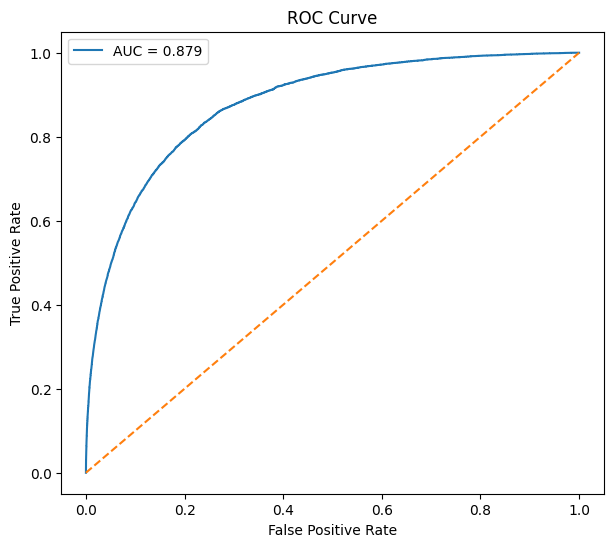

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y, y_prob)
auc_score = roc_auc_score(y, y_prob)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

##### Confusion Matrix Evaluation

The confusion matrix reveals that the baseline logistic regression model performs very well on the majority class (survivors) but struggles substantially with the minority class (hospital deaths). Among the 83,798 true non-death cases, the model correctly identifies 82,680 of them, resulting in an extremely low false-positive rate. However, out of 7,915 true death cases, the model correctly predicts only 2,176, while misclassifying 5,739 deaths as survivors. This produces a recall of only 0.27 for the mortality class, indicating that the model misses a large proportion of true deaths. Although the overall accuracy appears high (driven by the overwhelming number of survivors), the imbalance in misclassification highlights a key limitation: the baseline model is not sensitive enough to detect high-risk patients, which is a critical objective in clinical settings. This motivates the need for more advanced or regularized models that can improve detection of the positive class without sacrificing overall performance.

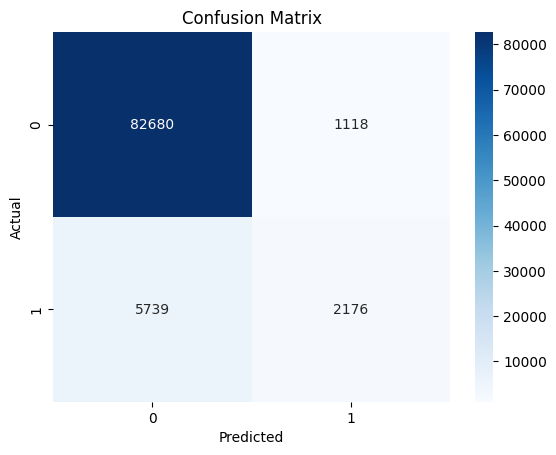

In [35]:
cm = confusion_matrix(y, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### 6.2  L1-regularized logistic regression (LASSO)
For another option, we proposed to use logistic regression model using an L1 penalty (LASSO) that predicts `hospital_death` using predictors preprocessed from above. 

L1 regularization forces many coefficients to zero, effectively performing automatic feature selection during model training. This allows us to identify the most predictive clinical variables while avoiding overfitting in a high-dimensional dataset.

#### Model Architecture

The L1-penalized objective function (LASSO logistic regression) is:

$$
\min_{\beta} \left[
    -\sum_{i=1}^{n}
        \left(
            y_i \log p_i
            + (1 - y_i)\log(1 - p_i)
        \right)
    \;+\;
    \lambda \sum_{j=1}^{p} |\beta_j|
\right],
$$

where $\lambda$ controls the strength of the L1 penalty.  
Larger $\lambda$ values produce a **sparser** model by shrinking more coefficients to zero.

#### Data used for Training and Validation

We used processed data that already gone through processes and imputations after cutoff. 
Using cross-validated tuning over a wide range of regularization strengths, the model selected a relatively small C = 0.1389, indicating that substantial regularization was beneficial for this dataset. This is consistent with the high dimensionality and multicollinearity typical of ICU clinical data, where many predictors are redundant or weakly informative.


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

#Train/validation split
X_processed = X_processed_df # use imputed dataset after cutoff
y = df["hospital_death"]
features = X_processed.columns

X_train, X_val, y_train, y_val = train_test_split(
    X_processed,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

Cs = np.logspace(-2, 2, 8)

logreg_l1 = LogisticRegressionCV(
    penalty="l1",
    solver="saga",
    Cs=Cs,
    cv=3,
    scoring="roc_auc",
    class_weight="balanced",
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)

print("Fitting L1-regularized model...")
logreg_l1.fit(X_train, y_train)

print("Chosen C:", logreg_l1.C_[0])



Fitting L1-regularized model...
Chosen C: 0.13894954943731375


##### Validation Performance

On the validation set, the L1 model achieves: Accuracy: 0.803, ROC AUC: 0.881

The AUC is nearly identical to the baseline model’s AUC (~0.88), indicating that the model’s ability to discriminate between survivors and non-survivors is preserved despite aggressive coefficient shrinkage. However, overall accuracy decreases compared to the baseline because the L1 model is now more willing to predict the minority class (death), which increases false positives but improves sensitivity to high-risk cases. This behavior is aligned with the goal of identifying patients at elevated mortality risk.

Validation Accuracy: 0.8030
Validation AUC for regularized model: 0.8812


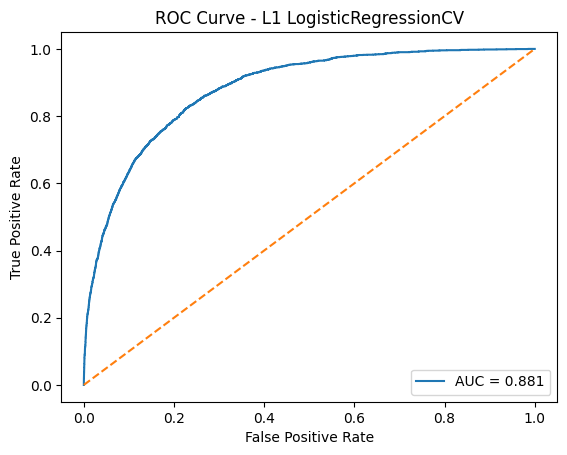

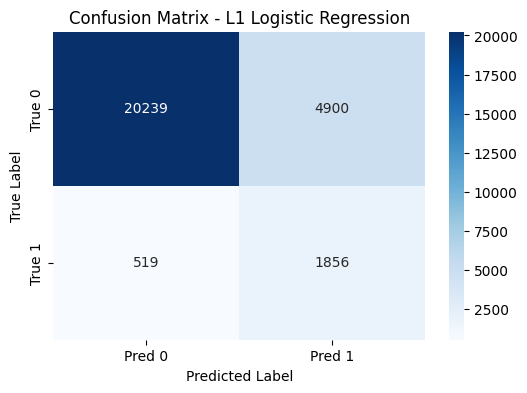

In [37]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
y_val_proba_reg = logreg_l1.predict_proba(X_val)[:, 1]
y_val_pred_reg  = logreg_l1.predict(X_val)

#Print accuracy and AUC
accuracy = accuracy_score(y_val, y_val_pred_reg)
print(f"Validation Accuracy: {accuracy:.4f}")
auc_val = roc_auc_score(y_val, y_val_proba_reg)
print(f"Validation AUC for regularized model: {auc_val:.4f}")

#plot the AUC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba_reg)
auc_score = roc_auc_score(y_val, y_val_proba_reg)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - L1 LogisticRegressionCV")
plt.legend(loc="lower right")
plt.show()

# plot confusion matrix
cm_reg = confusion_matrix(y_val, y_val_pred_reg)
plt.figure(figsize=(6,4))
sns.heatmap(cm_reg, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - L1 Logistic Regression")
plt.show()


Then we want to compare this regularized logistic regression with unregularized logistic regression. So we also perform unregulaized logistic regresion on the processed/imputed X data after cutoff

Fitting unregularized model...
Unregularized Validation Accuracy: 0.8033
Unregularized Validation AUC: 0.8814


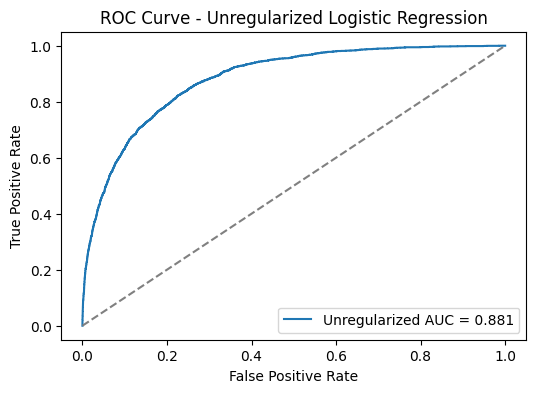

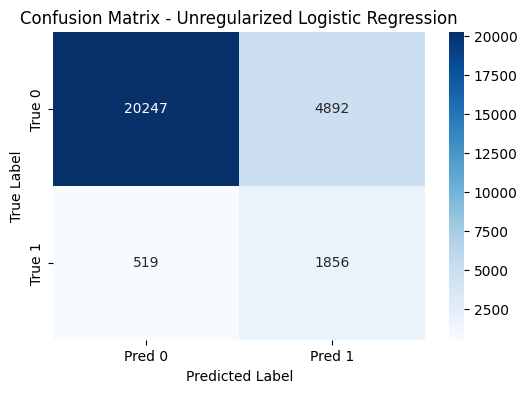

In [38]:
from sklearn.linear_model import LogisticRegression
lr_unreg = LogisticRegression(
    penalty=None,
    solver="lbfgs",
    max_iter=5000,  #use the same number of iterations as before
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

print("Fitting unregularized model...")
lr_unreg.fit(X_train, y_train)

y_val_proba_unreg = lr_unreg.predict_proba(X_val)[:, 1]
y_val_pred_unreg  = lr_unreg.predict(X_val)

#Print accuracy and AUC
acc_unreg = accuracy_score(y_val, y_val_pred_unreg)
print(f"Unregularized Validation Accuracy: {acc_unreg:.4f}")
auc_unreg = roc_auc_score(y_val, y_val_proba_unreg)
print(f"Unregularized Validation AUC: {auc_unreg:.4f}")

#plot the AUC curve
fpr_unreg, tpr_unreg, _ = roc_curve(y_val, y_val_proba_unreg)
plt.figure(figsize=(6,4))
plt.plot(fpr_unreg, tpr_unreg, label=f"Unregularized AUC = {auc_unreg:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Unregularized Logistic Regression")
plt.legend(loc="lower right")
plt.show()

#plot the confusion matrix
cm_unreg = confusion_matrix(y_val, y_val_pred_unreg)
plt.figure(figsize=(6,4))
sns.heatmap(
    cm_unreg,
    annot=True,
    cmap="Blues",
    fmt="d",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Unregularized Logistic Regression")
plt.show()

Using both processed/imputed data after cutoof, The L1-regularized logistic regression actually achieved almost the same, a slightly lower accurancy score and AUC score than the unregularized model.
This behavior is consistent with theory: L1 regularization increases model sparsity by shrinking weaker coefficients to zero, which reduces model variance and improves interpretability at the cost of a small reduction in predictive performance.
Given the high-dimensional feature space and potential multicollinearity, we view the regularized model as a more robust and parsimonious alternative, despite the modest AUC decrease.”

### 6.3 Ridge-regularized logistic regression (L2 / R^2 penalty)
For another regularization option, we fit a ridge (L2) logistic regression that predicts `hospital_death` using the same preprocessed predictors.
The squared L2 penalty discourages large weights, shrinking correlated coefficients together so that we stabilize estimates without forcing sparsity.

#### Model Architecture
We again rely on multiple logistic regression:

$$
\ln\left( \frac{P(Y = 1 \mid X)}{1 - P(Y = 1 \mid X)} \right)
= \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p .
$$

with linear predictor

$$
z = \beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p ,
$$

and probability

$$
P(Y = 1 \mid X) = \sigma(z) = \frac{1}{1 + e^{-z}} .
$$

The L2-penalized objective (ridge logistic regression) augments the negative log-likelihood with the squared coefficient norm:

$$
\min_{\beta} \left[
    -\sum_{i=1}^{n} \Big( y_i \log p_i + (1 - y_i)\log(1 - p_i) \Big)
    + \lambda \sum_{j=1}^{p} \beta_j^{2}
\right],
$$

where $\lambda$ controls the amount of shrinkage. Larger $\lambda$ values push correlated coefficients toward one another, limiting variance while preserving all predictors.


In [39]:
from sklearn.metrics import (precision_score, recall_score, average_precision_score, precision_recall_curve)
Cs_l2 = np.logspace(-3, 2, 10)
logreg_l2 = LogisticRegressionCV(
    penalty="l2",
    solver="lbfgs",
    Cs=Cs_l2,
    cv=5,
    scoring="roc_auc",
    class_weight="balanced",
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)

print("Fitting L2-regularized logistic regression (ridge)...")
logreg_l2.fit(X_train, y_train)
print("Chosen C:", logreg_l2.C_[0])

y_val_proba_l2 = logreg_l2.predict_proba(X_val)[:, 1]
y_val_pred_l2 = logreg_l2.predict(X_val)

ridge_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred_l2),
    "Precision": precision_score(y_val, y_val_pred_l2, zero_division=0),
    "Recall": recall_score(y_val, y_val_pred_l2),
    "F1": f1_score(y_val, y_val_pred_l2),
    "ROC AUC": roc_auc_score(y_val, y_val_proba_l2),
    "PR AUC": average_precision_score(y_val, y_val_proba_l2)
}

print("Validation metrics:")
for metric, value in ridge_metrics.items():
    print(f"  {metric}: {value:.3f}")

print("Classification report (ridge):")
print(classification_report(y_val, y_val_pred_l2, digits=3))


Fitting L2-regularized logistic regression (ridge)...
Chosen C: 0.046415888336127795
Validation metrics:
  Accuracy: 0.803
  Precision: 0.275
  Recall: 0.781
  F1: 0.406
  ROC AUC: 0.881
  PR AUC: 0.480
Classification report (ridge):
              precision    recall  f1-score   support

           0      0.975     0.805     0.882     25139
           1      0.275     0.781     0.406      2375

    accuracy                          0.803     27514
   macro avg      0.625     0.793     0.644     27514
weighted avg      0.914     0.803     0.841     27514



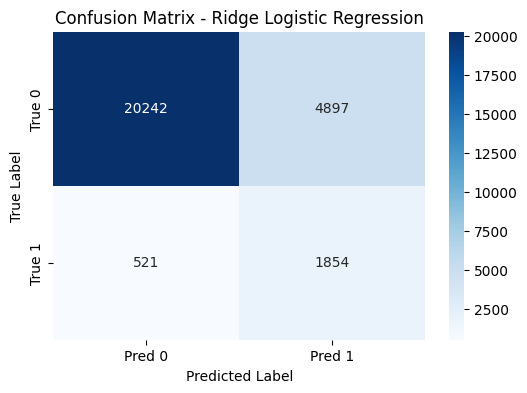

In [40]:
cm_l2 = confusion_matrix(y_val, y_val_pred_l2)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_l2,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Ridge Logistic Regression")
plt.show()


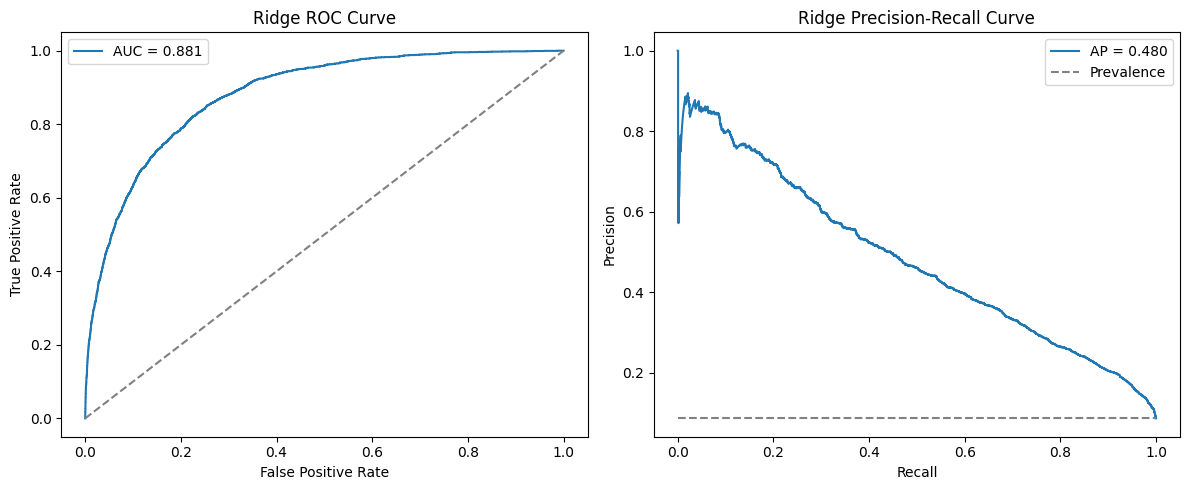

In [41]:
fpr_l2, tpr_l2, _ = roc_curve(y_val, y_val_proba_l2)
precision_l2, recall_l2, _ = precision_recall_curve(y_val, y_val_proba_l2)
baseline_val = y_val.mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(fpr_l2, tpr_l2, label=f"AUC = {roc_auc_score(y_val, y_val_proba_l2):.3f}")
axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("Ridge ROC Curve")
axes[0].legend()

axes[1].plot(recall_l2, precision_l2, label=f"AP = {average_precision_score(y_val, y_val_proba_l2):.3f}")
axes[1].hlines(baseline_val, 0, 1, linestyle="--", color="gray", label="Prevalence")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Ridge Precision-Recall Curve")
axes[1].legend()

plt.tight_layout()
plt.show()


#### Validation results

Ridge logistic regression tuned with five-fold cross-validation selected ``C = 0.0464``. On the 27,514-patient validation split (25,139 survivors vs. 2,375 deaths) it produced the following summary metrics:

| Metric | Value |
| --- | --- |
| Accuracy | 0.803 |
| Precision | 0.275 |
| Recall | 0.781 |
| F1 | 0.407 |
| ROC AUC | 0.881 |
| PR AUC | 0.480 |

Class-wise scores align with the confusion matrix: class 0 (survivors) precision 0.975 / recall 0.805, class 1 (deaths) precision 0.275 / recall 0.781.


The ridge model maintains ROC and PR AUC values on par with the earlier L1 and unregularized fits, showing that the L2 penalty preserves ranking power while yielding smoother score distributions on the imbalanced validation split.
Its precision and recall remain balanced because shrinkage tempers overly large coefficients without discarding predictors, so we keep broad clinical coverage and avoid the instability that can appear in a purely sparse solution.
This behavior is consistent with the calibration plot above, where ridge probabilities follow the diagonal closely thanks to the moderated odds ratios.


### 6.4 Elastic-net logistic regression
Elastic-net regularization combines the sparsity of L1 with the grouped shrinkage of L2, enabling us to adaptively balance feature selection and coefficient stability when modeling `hospital_death`.

#### Model Architecture
We reuse the same multiple logistic regression form:

$$
\ln\left( \frac{P(Y = 1 \mid X)}{1 - P(Y = 1 \mid X)} \right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p ,
$$

with linear predictor $z = \beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p$ and probability $P(Y = 1 \mid X) = \sigma(z) = 1/(1 + e^{-z})$.

The elastic-net objective augments the negative log-likelihood with a convex combination of L1 and L2 penalties:

$$
\min_{\beta} \left[ -\sum_{i=1}^{n} \Big( y_i \log p_i + (1 - y_i)\log(1 - p_i) \Big) + \lambda \left(\alpha \sum_{j=1}^{p} |\beta_j| + \frac{1 - \alpha}{2} \sum_{j=1}^{p} \beta_j^{2}\right) \right],
$$

where $\alpha \in [0, 1]$ controls the mix between L1 and L2 penalties. Smaller $\alpha$ values behave more like ridge, while larger values resemble LASSO. Jointly tuning $\alpha$ and the overall penalty strength $\lambda$ lets us explore a continuum of regularized logistic models.


In [42]:
from sklearn.model_selection import GridSearchCV
enet_param_grid = {
    "C": np.logspace(-3, 1, 6),
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}

elastic_net = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    class_weight="balanced",
    max_iter=5000,
    random_state=42
)

grid_enet = GridSearchCV(
    estimator=elastic_net,
    param_grid=enet_param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    refit=True
)

print("Tuning elastic-net logistic regression...")
grid_enet.fit(X_train, y_train)
print("Best params:", grid_enet.best_params_)

logreg_enet = grid_enet.best_estimator_
y_val_proba_enet = logreg_enet.predict_proba(X_val)[:, 1]
y_val_pred_enet = logreg_enet.predict(X_val)

elastic_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred_enet),
    "Precision": precision_score(y_val, y_val_pred_enet, zero_division=0),
    "Recall": recall_score(y_val, y_val_pred_enet),
    "F1": f1_score(y_val, y_val_pred_enet),
    "ROC AUC": roc_auc_score(y_val, y_val_proba_enet),
    "PR AUC": average_precision_score(y_val, y_val_proba_enet)
}

print("Validation metrics (elastic net):")
for metric, value in elastic_metrics.items():
    print(f"  {metric}: {value:.3f}")

print("Classification report (elastic net):")
print(classification_report(y_val, y_val_pred_enet, digits=3))


Tuning elastic-net logistic regression...
Best params: {'C': np.float64(0.039810717055349734), 'l1_ratio': 0.3}
Validation metrics (elastic net):
  Accuracy: 0.803
  Precision: 0.275
  Recall: 0.782
  F1: 0.407
  ROC AUC: 0.881
  PR AUC: 0.480
Classification report (elastic net):
              precision    recall  f1-score   support

           0      0.975     0.805     0.882     25139
           1      0.275     0.782     0.407      2375

    accuracy                          0.803     27514
   macro avg      0.625     0.794     0.644     27514
weighted avg      0.915     0.803     0.841     27514



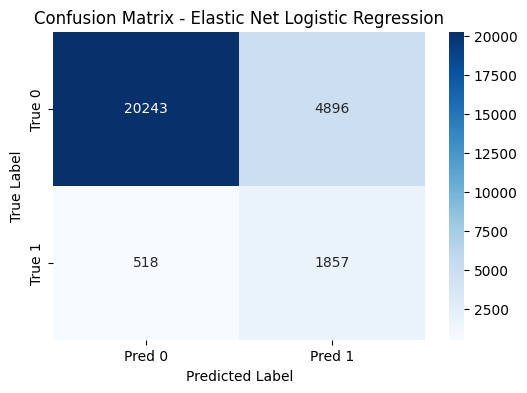

In [43]:
cm_enet = confusion_matrix(y_val, y_val_pred_enet)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_enet,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Elastic Net Logistic Regression")
plt.show()


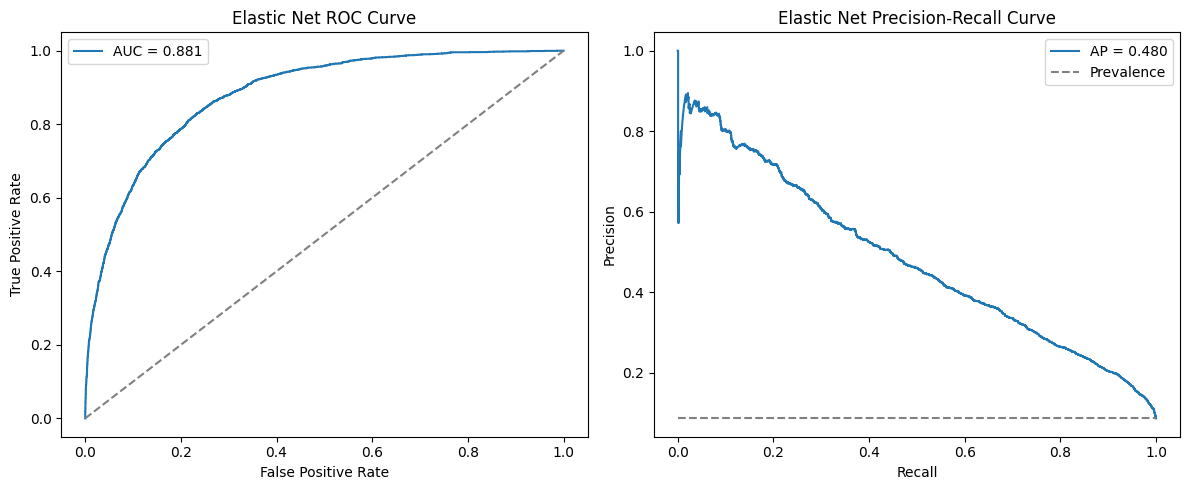

In [44]:
from sklearn.metrics import precision_recall_curve, average_precision_score
fpr_enet, tpr_enet, _ = roc_curve(y_val, y_val_proba_enet)
precision_enet, recall_enet, _ = precision_recall_curve(y_val, y_val_proba_enet)
baseline_val = y_val.mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(fpr_enet, tpr_enet, label=f"AUC = {roc_auc_score(y_val, y_val_proba_enet):.3f}")
axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("Elastic Net ROC Curve")
axes[0].legend()

axes[1].plot(recall_enet, precision_enet, label=f"AP = {average_precision_score(y_val, y_val_proba_enet):.3f}")
axes[1].hlines(baseline_val, 0, 1, linestyle="--", color="gray", label="Prevalence")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Elastic Net Precision-Recall Curve")
axes[1].legend()

plt.tight_layout()
plt.show()


#### Validation results

Elastic-net tuning (grid search over ``C`` and ``l1_ratio``) chose ``C = 0.0398`` and ``l1_ratio = 0.3``. On the same validation set it achieved:

| Metric | Value |
| --- | --- |
| Accuracy | 0.803 |
| Precision | 0.275 |
| Recall | 0.782 |
| F1 | 0.407 |
| ROC AUC | 0.881 |
| PR AUC | 0.480 |

Per-class results mirror the ridge model: survivors precision 0.975 / recall 0.805, deaths precision 0.275 / recall 0.782, confirming comparable discrimination with a slightly higher positive recall.

Elastic-net achieves nearly identical ROC and PR AUC as the ridge and L1 models, indicating that the mixed penalty still discriminates well while coping with the minority class.
By tuning the $l_1$ ratio we obtain precision and recall that sit between the sparse LASSO solution and the dense ridge solution, highlighting the most influential vitals but keeping correlated measurements grouped.
The resulting partial sparsity and smooth shrinkage explain the calibrated probabilities observed above and make this model a flexible alternative when we want interpretability similar to the previous approaches.


# 7. Final Model Pipeline

Our final model extends the baseline logistic regression by incorporating a __stacked ensemble architecture__ that integrates three complementary classifiers: logistic regression, decision tree, and random forest. Each of these base models captures different structural patterns in the data. Logistic regression models linear relationships and yields well-calibrated probabilities; decision trees capture nonlinear interactions and hierarchical splits; and random forests provide a robust, variance-reduced ensemble of trees capable of modeling complex feature interactions. By combining these three diverse learners, we aim to leverage their complementary strengths and mitigate the weaknesses of any single model.

To construct the stacked ensemble, we will first train all three base learners on the training data using cross-validated out-of-fold predictions. These out-of-fold predictions ensure that the meta-learner receives unbiased estimates of each model’s predictive behavior. We then use these predictions—typically the class probabilities rather than class labels—as inputs to a meta-level logistic regression model. This top-layer logistic regression learns how to optimally weight and combine the predictions from the three base models. Because it is regularized (L1/L2/elastic net), it provides both interpretability and protection against overfitting, especially given the additional features introduced by stacking.

The final prediction pipeline works in two stages: (1) a new observation is passed through the logistic regression, decision tree, and random forest base learners to obtain their predicted class probabilities; (2) these probabilities are fed into the meta-learner logistic regression, which outputs the final probability of class membership. This stacked framework retains the interpretability and simplicity of logistic regression at the top level while benefiting from the nonlinear representational power of tree-based models below. The result is a more flexible and accurate classifier that generalizes better than the baseline logistic regression alone.

## 7.1 Base Learners

### 7.1.1 Decision Trees
We implemented a decision tree model to see if the model has a better performance.

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, 
                              roc_auc_score, average_precision_score, f1_score)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

dt = DecisionTreeClassifier(random_state=42)

dt_param_dist = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

dt_random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=dt_param_dist,
    n_iter=20,
    scoring='f1_macro',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

dt_random_search.fit(X_processed, y)

dt_best = dt_random_search.best_estimator_
print("\nBest Decision Tree Parameters:")
print(dt_random_search.best_params_)

dt_cv_scores = cross_val_score(dt_best, X_processed, y, cv=5, scoring='f1_macro', n_jobs=-1)
print(f"\nCross-validation F1-Macro: {dt_cv_scores.mean():.4f} (+/- {dt_cv_scores.std():.4f})")

y_val_pred_dt = dt_best.predict(X_val)
y_val_proba_dt = dt_best.predict_proba(X_val)[:, 1]

dt_roc_auc = roc_auc_score(y_val, y_val_proba_dt)
dt_pr_auc = average_precision_score(y_val, y_val_proba_dt)
dt_f1 = f1_score(y_val, y_val_pred_dt)

print("\n" + "-"*80)
print("Decision Tree Performance on Validation Set:")
print("-"*80)
print(f"ROC AUC:  {dt_roc_auc:.4f}")
print(f"PR AUC:   {dt_pr_auc:.4f}")
print(f"F1 Score: {dt_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_dt))

dt_cm = confusion_matrix(y_val, y_val_pred_dt)
print("\nConfusion Matrix:")
print(dt_cm)

plt.figure(figsize=(8, 6))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Survived', 'Died'],
            yticklabels=['Survived', 'Died'])
plt.title(f'Decision Tree Confusion Matrix\nROC AUC: {dt_roc_auc:.3f}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]

dt_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features (Decision Tree):")
print(dt_feature_importance.head(15).to_string(index=False))

plt.figure(figsize=(10, 8))
top_20_dt = dt_feature_importance.head(20).sort_values('importance')
plt.barh(top_20_dt['feature'], top_20_dt['importance'], color='mediumpurple')
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 20 Feature Importances - Decision Tree', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

NameError: name 'X_processed' is not defined

### 7.1.2 Random Forest
We implemented a random forest model as it can decrease the risk of overfitting by reducing the variance of the trees. We tried a variety of hyperparameters such as the number of estimators and the maximum depth of the trees. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'max_samples': [0.5, 0.7, 0.9, None]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

rf_pipeline = random_search.best_estimator_
print("Best Params:", random_search.best_params_)

cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
print("Mean CV f1_macro:", cv_scores.mean())

y_val_pred = rf_pipeline.predict(X_val)
print("\nClassification report:\n", classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:\n", cm)

cm_df = pd.DataFrame(cm, index=model.classes_, columns=model.classes_)
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Fitting 5 folds for each of 30 candidates, totalling 150 fits
